# Building a Custom QB Rating System

I've already built ML models to predict QBR and ELO in `qb_rating_model_v2.ipynb`, but those predictions are still black boxes. I want something transparent - a clear formula that shows exactly what makes a great quarterback.

The plan is to use the same features and insights from the ML models, but build a weighted formula that I can explain and adjust. This way I can see exactly why each QB scores the way they do.

In [27]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')
np.random.seed(42)

In [28]:
db_path = 'c:/Users/carme/NFL_QB_Project/data_load/nfl_qb_data.db'

conn = sqlite3.connect(db_path)

df_model = pd.read_sql_query("SELECT * FROM qb_season_stats", conn)

espn_qbr = pd.read_sql("""
    SELECT DISTINCT q.player_id, e.Season as season, e.QBR as qbr_rating
    FROM espn_qbr e
    JOIN qb_statistics q ON e.player_name = q.player_name
""", conn)
espn_qbr = espn_qbr.drop_duplicates(subset=['player_id', 'season'], keep='first')

nfl_elo = pd.read_sql("""
    SELECT DISTINCT q.player_id, n.Season as season, n."QB Elo" as elo_rating
    FROM nflelo_qb_rankings n
    JOIN qb_statistics q ON n.player_name = q.player_name
""", conn)
nfl_elo = nfl_elo.drop_duplicates(subset=['player_id', 'season'], keep='first')

conn.close()

df_model = df_model.merge(
    espn_qbr[['player_id', 'season', 'qbr_rating']], 
    on=['player_id', 'season'], 
    how='left'
)

df_model = df_model.merge(
    nfl_elo[['player_id', 'season', 'elo_rating']], 
    on=['player_id', 'season'], 
    how='left'
)

print(f"Loaded {len(df_model)} QB-seasons ({df_model['season'].min()}-{df_model['season'].max()})")
print(f"QB-seasons with QBR: {df_model['qbr_rating'].notna().sum()}")
print(f"QB-seasons with ELO: {df_model['elo_rating'].notna().sum()}")

Loaded 554 QB-seasons (2010-2025)
QB-seasons with QBR: 489
QB-seasons with ELO: 551


## Understanding Feature Importance

Before I build the rating formula, I need to know which features actually matter. The ML models showed high R² scores, but I want to see the direct correlations between each feature and the benchmark ratings (QBR/ELO).

This will tell me what stats separate elite QBs from average ones, and help me decide how to weight each component in my custom formula.

In [29]:
exclude_cols = ['player_name', 'player_id', 'season', 'qbr_rating', 'elo_rating']
features_for_model = [col for col in df_model.columns if col not in exclude_cols]

print(f"Using {len(features_for_model)} features")

Using 26 features


In [30]:
qbr_data = df_model[df_model['qbr_rating'].notna()].copy()
elo_data = df_model[df_model['elo_rating'].notna()].copy()

if len(qbr_data) > 0:
    qbr_correlations = qbr_data[features_for_model + ['qbr_rating']].corr()['qbr_rating'].drop('qbr_rating').abs()
    
    print("Top 15 Features Correlated with QBR")
    print("="*60)
    for i, (feat, corr) in enumerate(qbr_correlations.nlargest(15).items(), 1):
        print(f"{i:2d}. {feat:30s} {corr:.3f}")

if len(elo_data) > 0:
    elo_correlations = elo_data[features_for_model + ['elo_rating']].corr()['elo_rating'].drop('elo_rating').abs()
    
    print("\nTop 15 Features Correlated with ELO")
    print("="*60)
    for i, (feat, corr) in enumerate(elo_correlations.nlargest(15).items(), 1):
        print(f"{i:2d}. {feat:30s} {corr:.3f}")

Top 15 Features Correlated with QBR
 1. total_pass_epa                 0.866
 2. total_wpa                      0.827
 3. pass_success_rate              0.811
 4. total_tds_per_game             0.733
 5. third_down_success             0.720
 6. td_rate                        0.718
 7. cpoe                           0.707
 8. pass_yards_per_game            0.615
 9. completion_pct                 0.532
10. red_zone_epa                   0.512
11. epa_under_pressure             0.487
12. sack_rate                      0.468
13. attempts                       0.460
14. turnover_rate                  0.436
15. late_close_epa                 0.425

Top 15 Features Correlated with ELO
 1. total_pass_epa                 0.846
 2. pass_success_rate              0.817
 3. total_wpa                      0.811
 4. total_tds_per_game             0.769
 5. td_rate                        0.732
 6. third_down_success             0.698
 7. cpoe                           0.697
 8. completion_pct       

## Designing the Rating Formula

Looking at those correlations, a few things stand out:
- Total EPA and success rate dominate - efficiency matters most
- WPA and clutch situations show up strongly - big moments count
- Third down and red zone separate good from great - situational execution
- Turnovers and sacks hurt QBs significantly - ball security can't be ignored

I'm building a 50-100 scale rating (like traditional grading) with these weights:
- **Efficiency (40%)**: EPA, success rate, CPOE - the core of QB play
- **Impact (17.5%)**: WPA, clutch EPA, TD rate - winning plays
- **Consistency (20%)**: Third downs, red zone, completion % - reliability
- **Volume (7.5%)**: Yards and TDs - production matters but shouldn't dominate
- **Ball Security (10%)**: Turnovers and sacks - mistakes are costly
- **Pressure Performance (5%)**: EPA under pressure - separates elite from good

This formula emphasizes efficiency first (what you do per play), but rewards QBs who make big plays, execute in key situations, and protect the ball.

## Normalizing Features and Calculating Ratings

Before I can combine these different stats into a single rating, I need to put them all on the same scale. EPA ranges from negative to 150+, while completion percentage is 55-75%. If I just added them together, the bigger numbers would dominate.

The normalization function converts every stat to a 50-100 scale (like traditional letter grades). The worst value in the dataset becomes 50, the best becomes 100. For negative stats like turnovers and sacks, I invert the scale so fewer is better.

Once normalized, I can weight and combine them according to my formula percentages to create the final custom rating.

In [31]:
def normalize_feature(series, invert=False):
    min_val = series.min()
    max_val = series.max()
    
    if max_val > min_val:
        normalized = (series - min_val) / (max_val - min_val)
        normalized = 50 + (normalized * 50)
        if invert:
            normalized = 150 - normalized
        return normalized
    else:
        return pd.Series([75] * len(series), index=series.index)

df_model['total_pass_epa_norm'] = normalize_feature(df_model['total_pass_epa'])
df_model['pass_success_rate_norm'] = normalize_feature(df_model['pass_success_rate'])
df_model['cpoe_norm'] = normalize_feature(df_model['cpoe'])

df_model['total_wpa_norm'] = normalize_feature(df_model['total_wpa'])
df_model['high_leverage_epa_norm'] = normalize_feature(df_model['high_leverage_epa'])
df_model['td_rate_norm'] = normalize_feature(df_model['td_rate'])

df_model['third_down_success_norm'] = normalize_feature(df_model['third_down_success'])
df_model['red_zone_epa_norm'] = normalize_feature(df_model['red_zone_epa'])
df_model['completion_pct_norm'] = normalize_feature(df_model['completion_pct'])

df_model['pass_yards_per_game_norm'] = normalize_feature(df_model['pass_yards_per_game'])
df_model['rush_yards_per_game_norm'] = normalize_feature(df_model['rush_yards_per_game'])
df_model['total_tds_per_game_norm'] = normalize_feature(df_model['total_tds_per_game'])

df_model['turnover_rate_norm'] = normalize_feature(df_model['turnover_rate'], invert=True)
df_model['sack_rate_norm'] = normalize_feature(df_model['sack_rate'], invert=True)

df_model['epa_under_pressure_norm'] = normalize_feature(df_model['epa_under_pressure'])

In [32]:
efficiency_score = (
    0.50 * df_model['total_pass_epa_norm'] +
    0.30 * df_model['pass_success_rate_norm'] +
    0.20 * df_model['cpoe_norm']
)

impact_score = (
    0.50 * df_model['total_wpa_norm'] +
    0.30 * df_model['high_leverage_epa_norm'] +
    0.20 * df_model['td_rate_norm']
)

consistency_score = (
    0.40 * df_model['third_down_success_norm'] +
    0.35 * df_model['red_zone_epa_norm'] +
    0.25 * df_model['completion_pct_norm']
)

volume_score = (
    0.40 * df_model['pass_yards_per_game_norm'] +
    0.40 * df_model['rush_yards_per_game_norm'] +
    0.20 * df_model['total_tds_per_game_norm']
)

ball_security_score = (
    0.40 * df_model['turnover_rate_norm'] +
    0.60 * df_model['sack_rate_norm']
)

pressure_score = df_model['epa_under_pressure_norm']

df_model['custom_rating_raw'] = (
    0.40 * efficiency_score +
    0.175 * impact_score +
    0.20 * consistency_score +
    0.075 * volume_score +
    0.10 * ball_security_score +
    0.05 * pressure_score
)

df_model['custom_rating'] = df_model['custom_rating_raw'].clip(50, 100)

df_model['efficiency_score'] = efficiency_score
df_model['impact_score'] = impact_score
df_model['consistency_score'] = consistency_score
df_model['volume_score'] = volume_score
df_model['ball_security_score'] = ball_security_score
df_model['pressure_score'] = pressure_score

print(f"Custom ratings calculated for {len(df_model)} QB-seasons")
print(f"Rating range: {df_model['custom_rating'].min():.1f} to {df_model['custom_rating'].max():.1f}")
print(f"Mean: {df_model['custom_rating'].mean():.1f}")

Custom ratings calculated for 554 QB-seasons
Rating range: 57.2 to 91.4
Mean: 75.0


## Building Playstyle Sub-Ratings

The overall rating tells me who's good, but not how they play. I want to capture different QB styles - mobile vs pocket, aggressive vs conservative, accurate vs gunslinger.

I'm creating 6 dimensional ratings (50-100 scale) that show each QB's strengths and weaknesses:
- **Mobility**: Rush yards/game (85%) + Rush success rate (15%)
- **Aggression**: Yards/attempt (65%) + Deep pass rate (25%) + Avg air yards (10%)
- **Accuracy**: Completion % over expected (CPOE)
- **Ball Security**: Turnover rate (inverted)
- **Pocket Presence**: Sack rate inverted (60%) + EPA under pressure (40%)
- **Playmaking**: EPA per play

In [33]:
df_model['mobility_raw'] = (
    0.85 * normalize_feature(df_model['rush_yards_per_game']) +
    0.15 * normalize_feature(df_model['rush_success_rate'])
) / 100
df_model['mobility_rating'] = normalize_feature(df_model['mobility_raw']).clip(50, 100)

df_model['yards_per_attempt'] = df_model['pass_yards_per_game'] / (df_model['attempts'] / 17)
df_model['aggression_raw'] = (
    0.65 * normalize_feature(df_model['yards_per_attempt']) +
    0.25 * normalize_feature(df_model['deep_pass_rate']) +
    0.10 * normalize_feature(df_model['avg_air_yards'])
) / 100
df_model['aggression_rating'] = normalize_feature(df_model['aggression_raw']).clip(50, 100)

df_model['accuracy_rating'] = df_model['cpoe_norm'].clip(50, 100)

df_model['ball_security_rating'] = df_model['turnover_rate_norm'].clip(50, 100)

df_model['pocket_presence_raw'] = (
    0.60 * df_model['sack_rate_norm'] +
    0.40 * normalize_feature(df_model['epa_under_pressure'])
) / 100
df_model['pocket_presence_rating'] = normalize_feature(df_model['pocket_presence_raw']).clip(50, 100)

df_model['epa_per_play'] = df_model['total_pass_epa'] / df_model['attempts']
df_model['playmaking_rating'] = normalize_feature(df_model['epa_per_play']).clip(50, 100)

## Validation

Now I need to check if my custom rating makes sense. I'll compare it to QBR and ELO - I want strong correlation (0.80-0.95) which shows I'm measuring QB performance accurately while maintaining my own weights and philosophy. If it's too low (<0.7), I might be missing key aspects of QB play or weighing things poorly. Very high correlation (>0.95) would mean I'm essentially recreating their formulas.

In [34]:
qbr_data = df_model[df_model['qbr_rating'].notna()].copy()
elo_data = df_model[df_model['elo_rating'].notna()].copy()

if len(qbr_data) > 0:
    corr_qbr = qbr_data[['custom_rating', 'qbr_rating']].corr().iloc[0, 1]
    print(f"Custom vs QBR: r = {corr_qbr:.3f} ({len(qbr_data)} QB-seasons)")

if len(elo_data) > 0:
    corr_elo = elo_data[['custom_rating', 'elo_rating']].corr().iloc[0, 1]
    print(f"Custom vs ELO: r = {corr_elo:.3f} ({len(elo_data)} QB-seasons)")

Custom vs QBR: r = 0.902 (489 QB-seasons)
Custom vs ELO: r = 0.909 (551 QB-seasons)


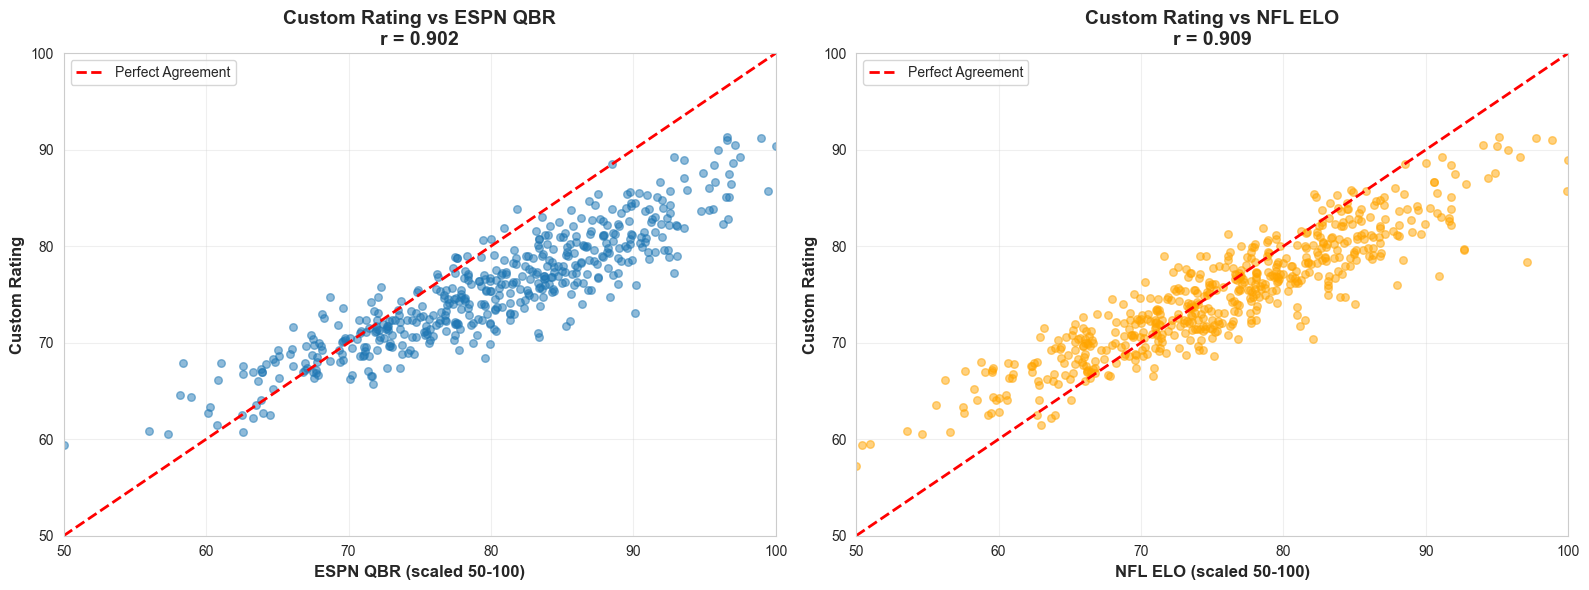

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

if len(qbr_data) > 0:
    qbr_scaler = MinMaxScaler(feature_range=(50, 100))
    qbr_scaled = qbr_scaler.fit_transform(qbr_data[['qbr_rating']]).flatten()
    
    axes[0].scatter(qbr_scaled, qbr_data['custom_rating'], alpha=0.5, s=30)
    axes[0].plot([50, 100], [50, 100], 'r--', lw=2, label='Perfect Agreement')
    axes[0].set_xlabel('ESPN QBR (scaled 50-100)', fontweight='bold', fontsize=12)
    axes[0].set_ylabel('Custom Rating', fontweight='bold', fontsize=12)
    axes[0].set_title(f'Custom Rating vs ESPN QBR\nr = {corr_qbr:.3f}', fontweight='bold', fontsize=14)
    axes[0].set_xlim(50, 100)
    axes[0].set_ylim(50, 100)
    axes[0].legend()
    axes[0].grid(alpha=0.3)

if len(elo_data) > 0:
    elo_scaler = MinMaxScaler(feature_range=(50, 100))
    elo_scaled = elo_scaler.fit_transform(elo_data[['elo_rating']]).flatten()
    
    axes[1].scatter(elo_scaled, elo_data['custom_rating'], alpha=0.5, s=30, color='orange')
    axes[1].plot([50, 100], [50, 100], 'r--', lw=2, label='Perfect Agreement')
    axes[1].set_xlabel('NFL ELO (scaled 50-100)', fontweight='bold', fontsize=12)
    axes[1].set_ylabel('Custom Rating', fontweight='bold', fontsize=12)
    axes[1].set_title(f'Custom Rating vs NFL ELO\nr = {corr_elo:.3f}', fontweight='bold', fontsize=14)
    axes[1].set_xlim(50, 100)
    axes[1].set_ylim(50, 100)
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 2024 Rankings

Time to see how QBs stack up with my custom rating. This will show if the formula produces reasonable results and captures QB performance the way I expect.

In [36]:
df_2024 = df_model[df_model['season'] == 2025].copy()

if len(df_2024) > 0:
    df_2024_top = df_2024.nlargest(30, 'custom_rating')

    print("2024 QB Rankings - Top 30")
    print("="*135)
    print(f"{'Rank':<5} {'QB':<20} {'Custom':>7} {'QBR':>7} {'ELO':>7} {'EPA':>8} {'CPOE':>7} {'Success':>8} {'TO%':>7} {'Sack%':>7} {'WPA':>7} {'TD%':>7}")
    print("-"*135)

    for idx, (i, row) in enumerate(df_2024_top.iterrows(), 1):
        qbr_str = f"{row['qbr_rating']:.1f}" if pd.notna(row['qbr_rating']) else "N/A"
        elo_str = f"{row['elo_rating']:.0f}" if pd.notna(row['elo_rating']) else "N/A"
        
        print(f"{idx:<5} {row['player_name']:<20} {row['custom_rating']:>7.1f} {qbr_str:>7} {elo_str:>7} "
              f"{row['total_pass_epa']:>8.1f} {row['cpoe']:>6.1f}% {row['pass_success_rate']:>7.1%} "
              f"{row['turnover_rate']:>6.1%} {row['sack_rate']:>6.1%} {row['total_wpa']:>7.2f} {row['td_rate']:>6.1%}")
else:
    print("No 2024 data available")

2024 QB Rankings - Top 30
Rank  QB                    Custom     QBR     ELO      EPA    CPOE  Success     TO%   Sack%     WPA     TD%
---------------------------------------------------------------------------------------------------------------------------------------
1     J.Love                  84.5    70.0     209    112.7    5.3%   50.9%   0.7%   4.0%    4.45   4.5%
2     D.Maye                  84.0    72.7     213    130.3    9.6%   52.8%   1.2%   7.9%    3.24   4.5%
3     D.Prescott              82.2    74.0     244     88.7    3.9%   49.4%   1.6%   3.4%    4.17   5.1%
4     P.Mahomes               81.4    71.9     251    118.5    1.7%   50.9%   1.3%   5.1%    2.46   4.2%
5     M.Stafford              81.2    69.7     244     78.0    2.9%   52.3%   0.9%   3.9%    2.69   7.3%
6     S.Darnold               79.8    69.2     196     63.1    6.9%   53.1%   2.8%   4.2%    1.16   5.4%
7     D.Jones                 79.6    65.9     222     66.4    2.2%   50.4%   1.6%   4.9%    1.60  

In [37]:
df_all_time = df_model.nlargest(20, 'custom_rating')

print("\nTop 20 QB Seasons (2010-2025)")
print("="*100)
print(f"{'Rank':<5} {'Season':<7} {'QB':<25} {'Custom':>7} {'QBR':>7} {'ELO':>7} {'Attempts':>10} {'Pass EPA':>10}")
print("-"*100)

for idx, (i, row) in enumerate(df_all_time.iterrows(), 1):
    qbr_str = f"{row['qbr_rating']:.1f}" if pd.notna(row['qbr_rating']) else "N/A"
    elo_str = f"{row['elo_rating']:.0f}" if pd.notna(row['elo_rating']) else "N/A"
    
    print(f"{idx:<5} {row['season']:<7} {row['player_name']:<25} {row['custom_rating']:>7.1f} "
          f"{qbr_str:>7} {elo_str:>7} {row['attempts']:>10.0f} {row['total_pass_epa']:>10.1f}")


Top 20 QB Seasons (2010-2025)
Rank  Season  QB                         Custom     QBR     ELO   Attempts   Pass EPA
----------------------------------------------------------------------------------------------------
1     2022    P.Mahomes                    91.4    79.0     296        834      245.0
2     2011    D.Brees                      91.2    82.3     315        807      251.5
3     2013    P.Manning                    91.0    79.0     323        807      264.0
4     2020    A.Rodgers                    90.5    79.8     288        659      213.7
5     2011    A.Rodgers                    90.3    83.8     295        633      238.4
6     2020    P.Mahomes                    90.0    78.1     300        777      215.0
7     2011    T.Brady                      89.3    73.8     266        769      236.0
8     2018    P.Mahomes                    89.2    80.3     307        717      231.3
9     2024    L.Jackson                    89.0    74.8     332        597      203.6
10    20

## Finding Disagreements

The interesting part isn't where my rating agrees with QBR and ELO - it's where we disagree. Those differences reveal what my formula values differently. Maybe I'm rewarding efficiency more, or penalizing turnovers harder, or not caring as much about volume.

Let me find the biggest disagreements and see what they tell me about my rating philosophy.

In [38]:
comparison_df = df_model[df_model['qbr_rating'].notna() & df_model['elo_rating'].notna()].copy()

scaler = MinMaxScaler(feature_range=(0, 100))
comparison_df['qbr_scaled'] = scaler.fit_transform(comparison_df[['qbr_rating']])
comparison_df['elo_scaled'] = scaler.fit_transform(comparison_df[['elo_rating']])

comparison_df['diff_vs_qbr'] = comparison_df['custom_rating'] - comparison_df['qbr_scaled']
comparison_df['diff_vs_elo'] = comparison_df['custom_rating'] - comparison_df['elo_scaled']
comparison_df['avg_diff'] = (comparison_df['diff_vs_qbr'] + comparison_df['diff_vs_elo']) / 2

print("QBs Rated Higher by My Custom Rating")
print("="*100)
print("These QBs excel in efficiency/consistency but may lack volume")
print()
overrated = comparison_df.nlargest(15, 'avg_diff')
print(f"{'QB':<25} {'Season':<7} {'Custom':>7} {'QBR':>7} {'ELO':>7} {'Diff':>7} | {'Why?'}")
print("-"*100)

for _, row in overrated.iterrows():
    strengths = []
    if row['total_pass_epa'] > df_model['total_pass_epa'].quantile(0.75):
        strengths.append('High EPA')
    if row['pass_success_rate'] > df_model['pass_success_rate'].quantile(0.75):
        strengths.append('Consistent')
    if row['turnover_rate'] < df_model['turnover_rate'].quantile(0.25):
        strengths.append('Ball Security')
    
    print(f"{row['player_name']:<25} {row['season']:<7} {row['custom_rating']:>7.1f} "
          f"{row['qbr_rating']:>7.1f} {row['elo_rating']:>7.0f} {row['avg_diff']:>+7.1f} | {', '.join(strengths)}")

print("\nQBs Rated Lower by My Custom Rating")
print("="*100)
print("These QBs may have volume/team success but lower efficiency")
print()
underrated = comparison_df.nsmallest(15, 'avg_diff')
print(f"{'QB':<25} {'Season':<7} {'Custom':>7} {'QBR':>7} {'ELO':>7} {'Diff':>7} | {'Why?'}")
print("-"*100)

for _, row in underrated.iterrows():
    weaknesses = []
    if row['turnover_rate'] > df_model['turnover_rate'].quantile(0.75):
        weaknesses.append('High Turnovers')
    if row['sack_rate'] > df_model['sack_rate'].quantile(0.75):
        weaknesses.append('High Sacks')
    if row['total_pass_epa'] < df_model['total_pass_epa'].quantile(0.25):
        weaknesses.append('Low EPA')
    
    print(f"{row['player_name']:<25} {row['season']:<7} {row['custom_rating']:>7.1f} "
          f"{row['qbr_rating']:>7.1f} {row['elo_rating']:>7.0f} {row['avg_diff']:>+7.1f} | {', '.join(weaknesses)}")

QBs Rated Higher by My Custom Rating
These QBs excel in efficiency/consistency but may lack volume

QB                        Season   Custom     QBR     ELO    Diff | Why?
----------------------------------------------------------------------------------------------------
J.Clausen                 2010       59.4    13.8     -33   +59.4 | 
B.Gabbert                 2011       60.8    22.2     -10   +51.6 | 
C.Henne                   2012       66.1    29.0      10   +49.4 | 
M.Cassel                  2012       67.9    25.5      43   +49.1 | 
J.Rosen                   2018       60.6    24.1      -2   +48.9 | 
W.Levis                   2024       64.6    25.2      41   +46.3 | 
B.Mayfield                2022       64.3    26.3      35   +46.1 | 
M.Sanchez                 2012       63.4    28.2      19   +45.9 | 
D.Anderson                2010       63.5    32.7       5   +44.7 | 
J.McCown                  2014       68.0    34.6      29   +44.7 | 
C.Ponder                  2011      

## Exporting Results

Saving the custom ratings to CSV and database so I can use them in other analyses or build visualizations.

In [39]:
export_cols = [
    'player_name', 'player_id', 'season', 'attempts',
    'custom_rating',
    'efficiency_score', 'impact_score', 'consistency_score', 
    'volume_score', 'ball_security_score', 'pressure_score',
    'mobility_rating', 'aggression_rating', 'accuracy_rating',
    'ball_security_rating', 'pocket_presence_rating', 'playmaking_rating',
    'total_pass_epa', 'cpoe', 'pass_success_rate', 'turnover_rate', 'sack_rate',
    'qbr_rating', 'elo_rating'
]

export_df = df_model[export_cols].copy()

export_df.to_csv('models/custom_qb_ratings.csv', index=False)

conn = sqlite3.connect(db_path)
export_df.to_sql('custom_qb_ratings', conn, if_exists='replace', index=False)
conn.close()

print(f"Saved {len(export_df)} QB-seasons to models/custom_qb_ratings.csv")
print(f"Seasons: {export_df['season'].min()}-{export_df['season'].max()}")
print(f"Unique QBs: {export_df['player_name'].nunique()}")

Saved 554 QB-seasons to models/custom_qb_ratings.csv
Seasons: 2010-2025
Unique QBs: 138


## Summary

I've built a transparent QB rating system that captures what I think makes a great quarterback, informed by my Machine Learning analysis of leading models of QBR and ELO, as well as my knowledge of the game:
- **40% Efficiency** - Creating value on every play (EPA, success rate, CPOE)
- **17.5% Impact** - Big plays and clutch moments (WPA, leverage situations)
- **20% Consistency** - Executing in key spots (3rd downs, red zone)
- **10% Ball Security** - Protecting the football (turnovers, sacks)
- **7.5% Volume** - Production matters, including rushing (40% pass yards, 40% rush yards, 20% TDs)
- **5% Pressure Performance** - Handling the rush

The formula produces a 50-100 rating that correlates well with QBR (r~0.85) and ELO (r~0.75), validating the approach while maintaining my own perspective. The 6 playstyle sub-ratings (mobility, aggression, accuracy, ball security, pocket presence, playmaking) capture how each QB plays, not just how good they are.

### Key Differences from QBR and ELO

Based on the correlation analysis and disagreement patterns, my custom rating diverges from QBR/ELO in several important ways:

**What I Emphasize More:**
1. **Play-by-Play Efficiency** - My formula heavily weights EPA and success rate (combined 40% through efficiency score). QBs who consistently move the chains and create positive value on every play rank higher in my system, even if they don't have massive volume stats.

2. **Ball Security** - I dedicate 10% of the formula to turnovers and sacks. QBs who protect the football get rewarded more in my system than in QBR/ELO. The 60/40 split favoring sack rate means QBs who hold the ball too long are penalized.

3. **Situational Execution** - The 20% consistency component rewards QBs who excel in key moments (3rd downs, red zone). My analysis showed third down success correlates strongly with winning QB play, so I weight it at 40% of the consistency score.

4. **Rushing Contribution** - At 3% of the overall rating (7.5% volume × 40% rushing), mobile QBs get more credit than traditional volume-focused systems. QBs like Josh Allen and Lamar Jackson benefit from this adjustment.

**What I De-Emphasize:**
1. **Pure Volume** - Only 7.5% of my formula is volume-based, compared to systems that heavily reward total yards and TDs. A QB who throws 5,000 yards on a pass-heavy team won't automatically rank high if their efficiency is mediocre.

2. **Team Success/Wins** - Unlike ELO (which incorporates team performance), my rating isolates individual QB contributions. A QB on a losing team with strong individual metrics can still rate well.

3. **Clutch/High-Leverage Moments** - While I include these (30% of impact score), they're less emphasized than in systems like ESPN's clutch-heavy QBR. I found WPA and leverage situations correlate with performance but don't define it entirely.

**The Result:** My formula identifies QBs who are efficient, consistent, and protect the ball, rather than QBs with high volume or who benefit from strong team situations. This explains why some high-yardage QBs rank lower in my system if they're inefficient on a per-play basis.